
### Objective of the notebook:

In this notebook, I will try to explore datasets in detail and make my first submission for this project to kaggle.

### Objective of the competition:

In this competition, we a’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer.

### About the dataset:

Similar to most other kaggle competitions, we are given two datasets

- train.csv
- test.csv
Each row in the dataset is one visit to the store. We are predicting the natural log of the sum of all transactions per user.

The data fields in the given files are

- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).

In [2]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import time
import datetime
import os

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.display.float_format = '{:,.2f}'.format

In [16]:
def load_dataset(dataset_path):
    
    dataset_name = os.path.basename(dataset_path)
    
    # columns contain json string
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # convert each column(which contains json) json string to json object
    df = pd.read_csv(dataset_path, converters = { column: json.loads for column in json_columns },
                      dtype = {'fullVisitorId' : 'str'})
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subColumn}" for subColumn in column_as_df.columns]
        df = df.drop(column, axis = 1).merge(column_as_df, left_index = True, right_index = True)
    
    print(f"--- Loaded {os.path.basename(dataset_path)}. Shape : {df.shape}")
    
    return df

In [17]:
%%time
train_path = 'train.csv'
train_df = load_dataset(train_path)

--- Loaded train.csv. Shape : (903653, 55)
Wall time: 1min 56s


In [18]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1.13166E+18,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,3.77306E+17,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3.89555E+18,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4.76345E+18,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,2.72944E+16,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [19]:
%%time
test_path = 'test.csv'
test_df = load_dataset(test_path)

--- Loaded test.csv. Shape : (804684, 53)
Wall time: 1min 46s


In [20]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


# Exploratory Data Analysis (EDA)

### Target Variable Exploration

Since we are predicting the natural log of sum of all transactions of the user, let us sum up the transaction revenue at user level and take a log and then do a scatter plot.

- reset_index() -> use numeric index instead of column as index

In [21]:
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].astype(float)
gdf = train_df.groupby('fullVisitorId')['totals_transactionRevenue'].sum().reset_index()

### Adjust Column Datatypes

In [22]:
train_df['device_isMobile'] = train_df['device_isMobile'].astype(float)

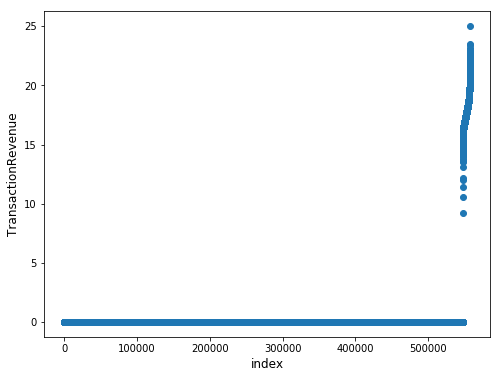

In [23]:
plt.figure(figsize = (8, 6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf['totals_transactionRevenue'].values)))
plt.xlabel('index', fontsize = 12)
plt.ylabel('TransactionRevenue', fontsize = 12)
plt.show()

The **80/20 rule** has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

In fact, the ratio is even less than **20.**

In [24]:
non_zero_revenue_rows = pd.notnull(train_df['totals_transactionRevenue']).sum()
non_zero_revenue_unique_customers = (gdf['totals_transactionRevenue'] > 0).sum()

print("Number of instances in train set with non-zero revenue : ", non_zero_revenue_rows, 
      " and ratio is : %.2f %%" %((non_zero_revenue_rows / train_df.shape[0]) * 100))

print("Number of unique customers in train set with non-zero revenue : ", non_zero_revenue_unique_customers, 
      "and the ratio is : %.2f %%" %((non_zero_revenue_unique_customers / gdf.shape[0]) * 100))

Number of instances in train set with non-zero revenue :  11515  and ratio is : 1.27 %
Number of unique customers in train set with non-zero revenue :  9964 and the ratio is : 1.79 %


- So the ratio of revenue generating customers is only **1.79 %**.

- Since most of the rows have **zero revenues**, in the following plots let us have a look at the **count of each category** of the variable along with the number of instances where the revenue is not zero.

Now let us look at the number of unique visitors in the train and test set and also the number of common visitors.

In [25]:
print("Number of unique visitors in train set : ", train_df['fullVisitorId'].nunique(),
      " out of rows : ", train_df.shape[0])

print("Number of unique visitors in test set : ", test_df['fullVisitorId'].nunique(), 
      " out of rows : ", test_df.shape[0])

print("Number of common visitors in train and test set : ", len(set(train_df['fullVisitorId'].unique())
      .intersection(set(test_df['fullVisitorId']))))

Number of unique visitors in train set :  557668  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  0


### Columns with constant values

Looks like there are quite a few features with constant value in the train set. Let us get the list of these features. We will
not include the columns for prediction which have constant and some null values.
- **Nan** will be considered a unique value.

In [26]:
const_cols = [ col for col in train_df.columns if train_df[col].nunique(dropna = False) == 1 ] 
const_cols

['socialEngagementType',
 'device_browserSize',
 'device_browserVersion',
 'device_flashVersion',
 'device_language',
 'device_mobileDeviceBranding',
 'device_mobileDeviceInfo',
 'device_mobileDeviceMarketingName',
 'device_mobileDeviceModel',
 'device_mobileInputSelector',
 'device_operatingSystemVersion',
 'device_screenColors',
 'device_screenResolution',
 'geoNetwork_cityId',
 'geoNetwork_latitude',
 'geoNetwork_longitude',
 'geoNetwork_networkLocation',
 'totals_visits',
 'trafficSource_adwordsClickInfo.criteriaParameters']

### Columns with non-constant values

In [27]:
non_const_cols = [ col for col in train_df.columns if train_df[col].nunique(dropna = False) > 1 ] 
non_const_cols

['channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device_browser',
 'device_deviceCategory',
 'device_isMobile',
 'device_operatingSystem',
 'geoNetwork_city',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'totals_bounces',
 'totals_hits',
 'totals_newVisits',
 'totals_pageviews',
 'totals_transactionRevenue',
 'trafficSource_adContent',
 'trafficSource_adwordsClickInfo.adNetworkType',
 'trafficSource_adwordsClickInfo.gclId',
 'trafficSource_adwordsClickInfo.isVideoAd',
 'trafficSource_adwordsClickInfo.page',
 'trafficSource_adwordsClickInfo.slot',
 'trafficSource_campaign',
 'trafficSource_campaignCode',
 'trafficSource_isTrueDirect',
 'trafficSource_keyword',
 'trafficSource_medium',
 'trafficSource_referralPath',
 'trafficSource_source']

In [28]:
def sort_value_and_index(df, feature, head_val):
    x_vals = df[str(feature)].sort_values(ascending = False).head(head_val).values
    y_vals = df[str(feature)].sort_values(ascending = False).head(head_val).index
    return x_vals, y_vals

In [29]:
def plot_horizontal_bar(x_vals, y_vals, color):
    plt.barh(y_vals, x_vals, color = color)
    plt.yticks(y_vals, rotation = 'horizontal', fontsize = 13)
    plt.xticks(fontsize = 12)

In [30]:
def plot_multiple_bars(cols_list, df, titles, colors, nrows = 2, ncols = 2, fig_x = 15, fig_y = 15, ws = 0.38, hs = None, head = 10):
    plt.subplots(figsize = (fig_x, fig_y))
    plt.subplots_adjust(wspace = ws, hspace = hs)
    for col in cols_list:
        index = cols_list.index(col)
        x_vals, y_vals = sort_value_and_index(df, col, head)
        plt.subplot(nrows, ncols, index + 1)
        plt.title(titles[index], color = 'b', fontsize = 16, x = 0.5, y = 1.02)
        plot_horizontal_bar(x_vals, y_vals, colors[index])

In [31]:
def cal_agg_df(feature):
    df = train_df.groupby(feature)['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
    df.columns = ['total_count', 'count_of_non_zero_revenue', 'mean_of_non_zero_revenue']
    cols_list = list(df.columns)
    return df, cols_list

## Device Information

- **size** and **count** find no. of rows per group
- **size** includes NaN values, **count** does not
- **mean** ignores NaN values

### Device Browser

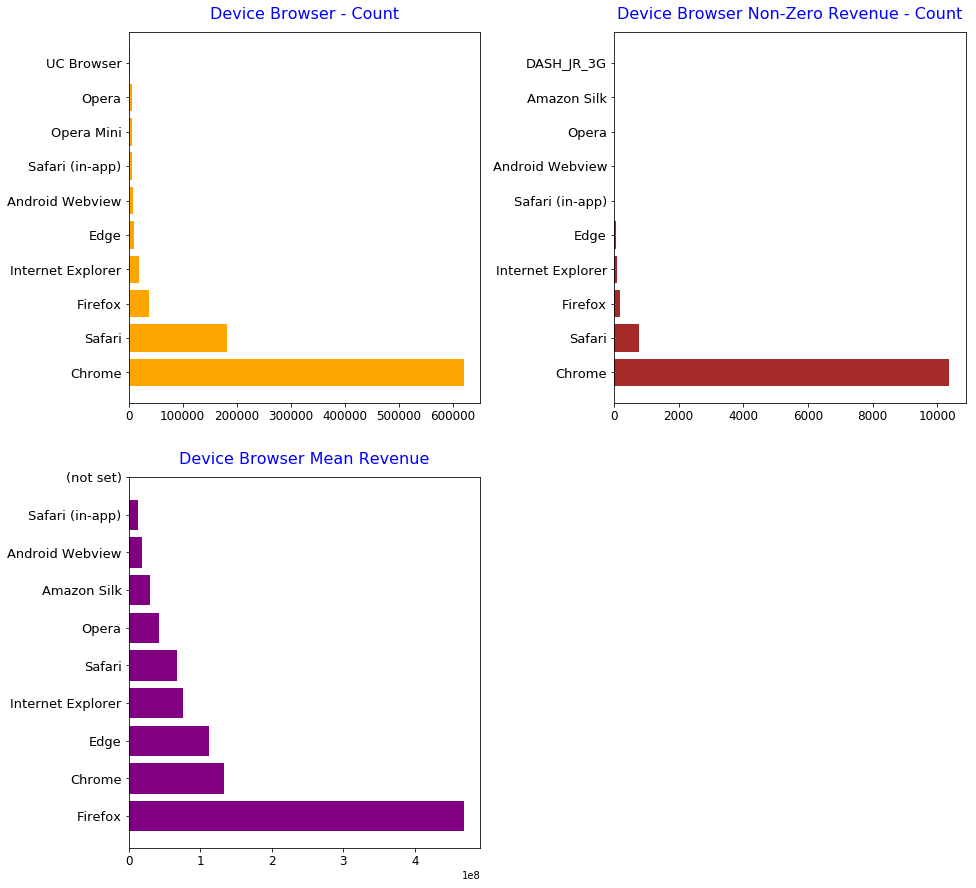

In [32]:
colors = ['orange', 'brown', 'purple']
titles = ['Device Browser - Count', 'Device Browser Non-Zero Revenue - Count', 'Device Browser Mean Revenue']

device_browser_agg_df, cols_list = cal_agg_df('device_browser')
plot_multiple_bars(cols_list, device_browser_agg_df, titles, colors)

### Device Category

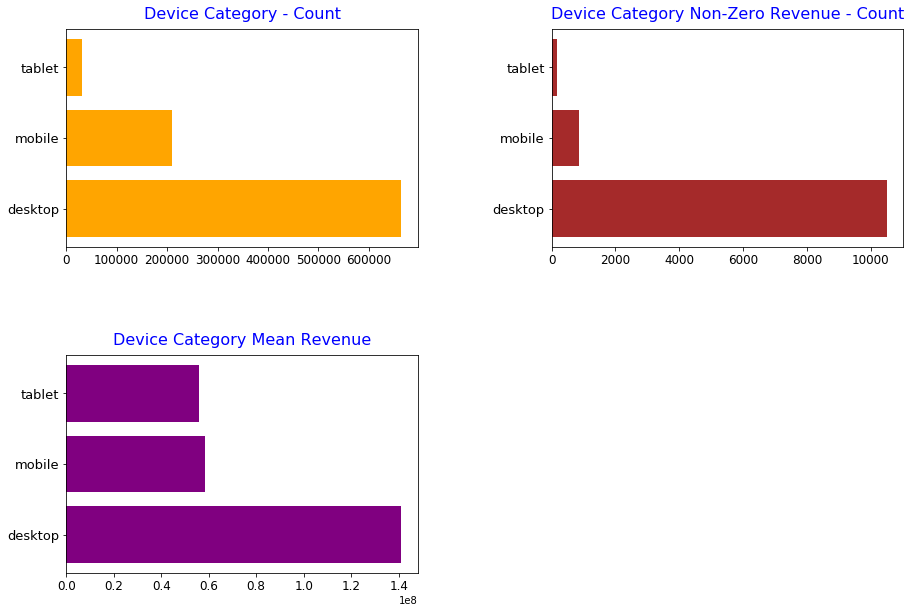

In [33]:
colors = ['orange', 'brown', 'purple']
titles = ['Device Category - Count', 'Device Category Non-Zero Revenue - Count', 'Device Category Mean Revenue']

device_deviceCategory_agg_df, cols_list = cal_agg_df('device_deviceCategory')
plot_multiple_bars(cols_list, device_deviceCategory_agg_df, titles, colors, fig_y = 10, hs = 0.5)

### Mobile Device 

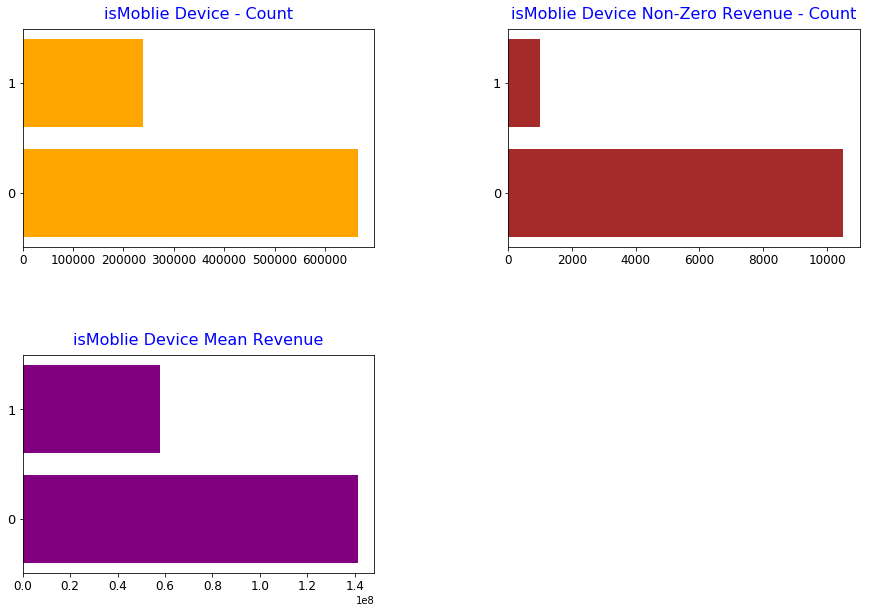

In [34]:
colors = ['orange', 'brown', 'purple']
titles = ['isMoblie Device - Count', 'isMoblie Device Non-Zero Revenue - Count', 'isMoblie Device Mean Revenue']

device_isMobile_agg_df, cols_list = cal_agg_df('device_isMobile')
plot_multiple_bars(cols_list, device_isMobile_agg_df, titles, colors, fig_y = 10, hs = 0.5)

### Device OperatingSystem

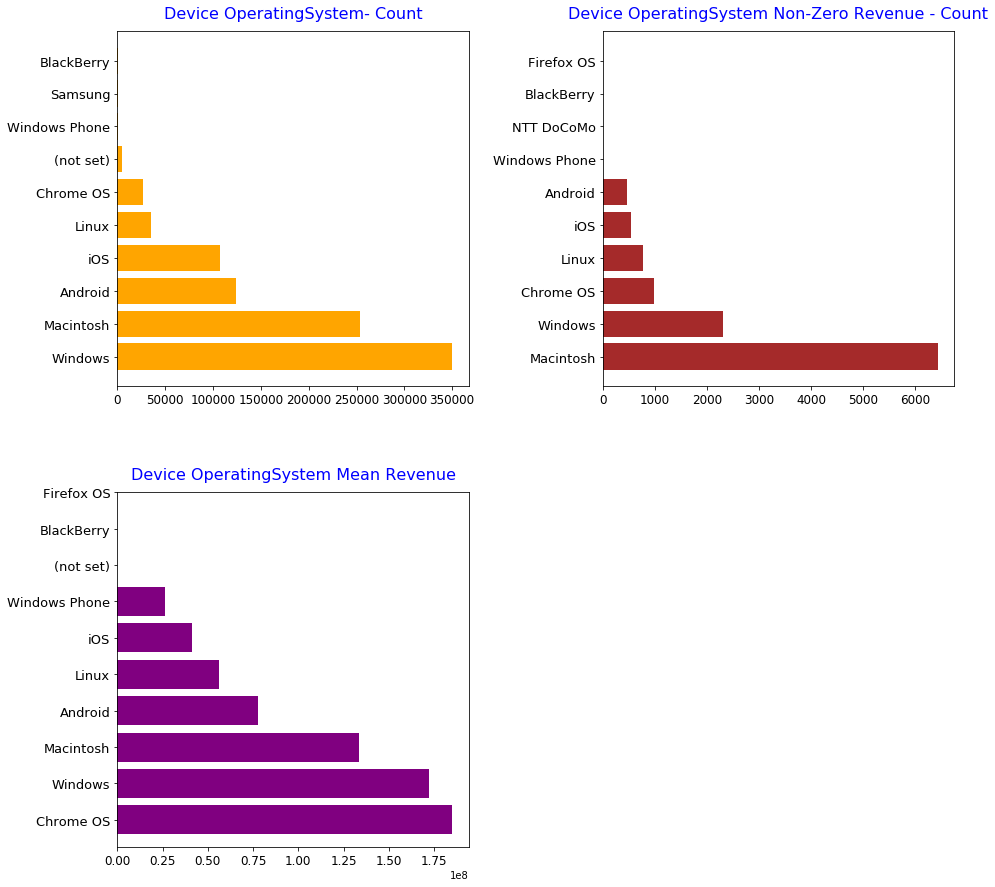

In [35]:
colors = ['orange', 'brown', 'purple']
titles = ['Device OperatingSystem- Count', 'Device OperatingSystem Non-Zero Revenue - Count', 
          'Device OperatingSystem Mean Revenue']

device_operatingSystem_agg_df, cols_list = cal_agg_df('device_operatingSystem')
plot_multiple_bars(cols_list, device_operatingSystem_agg_df, titles, colors, hs = 0.3)

### Inferences

- Chrome browser has highest overall count and non-zero revenue count.
- Firefox has highest mean revenue by beating chrome, edge, opera, safari etc.
- Desktop has highest count ,non-zero revenue count and mean revenue as well.
- Moblie has higher overall count and non-zero revenue count as compare to Tablet but mean revenue of tablet and moblie are nearly same.
- Macitosh has more non-zero revenue count than windows and Chrome OS.
- Chrome OS has more mean revenue than Windows and Macitosh even Chrome OS has less non-zero revenue count as compare to both Windows and Macintosh.

## Graphic Information

- We will explore all geonetowrk features and make some inferences.

### GeoNetwork City

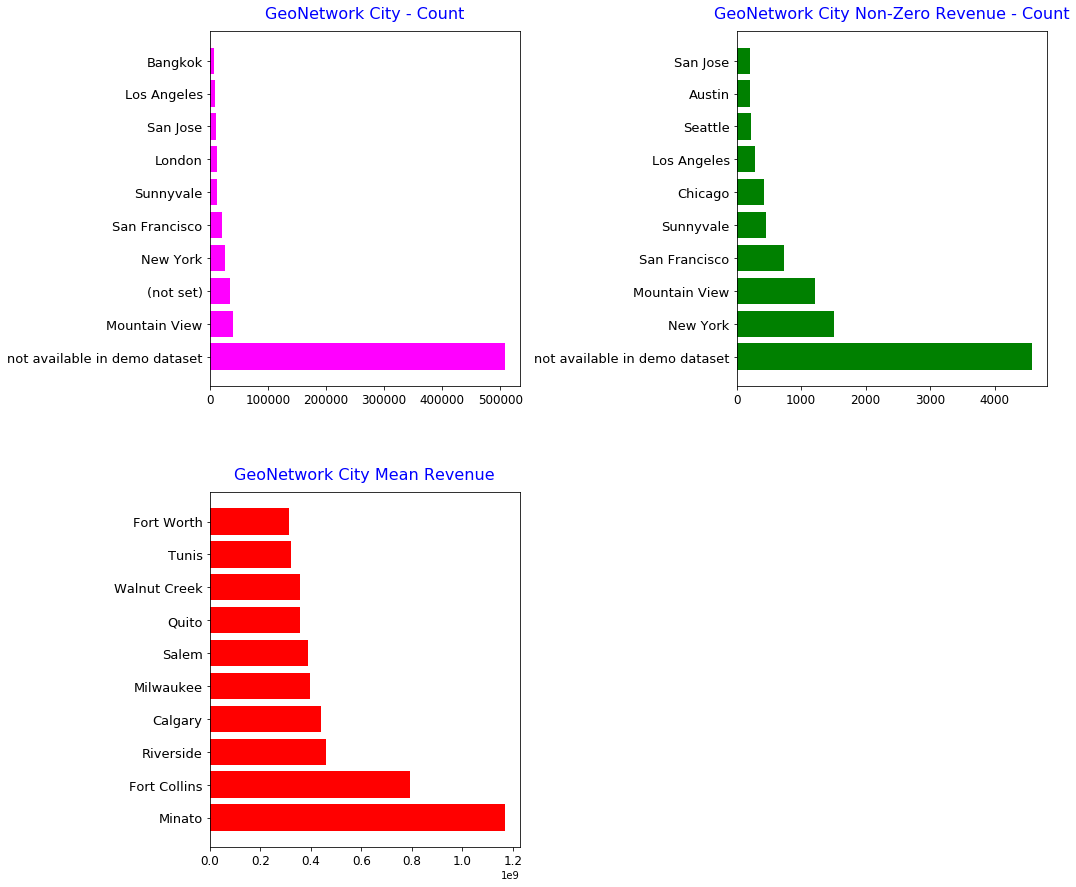

In [36]:
colors = ['magenta', 'green', 'red']
titles = ['GeoNetwork City - Count', 'GeoNetwork City Non-Zero Revenue - Count', 
          'GeoNetwork City Mean Revenue']

geoNetwork_city_agg_df, cols_list = cal_agg_df('geoNetwork_city')
plot_multiple_bars(cols_list, geoNetwork_city_agg_df, titles, colors, ws = 0.7, hs = 0.3)

### GeoNetwork Continent

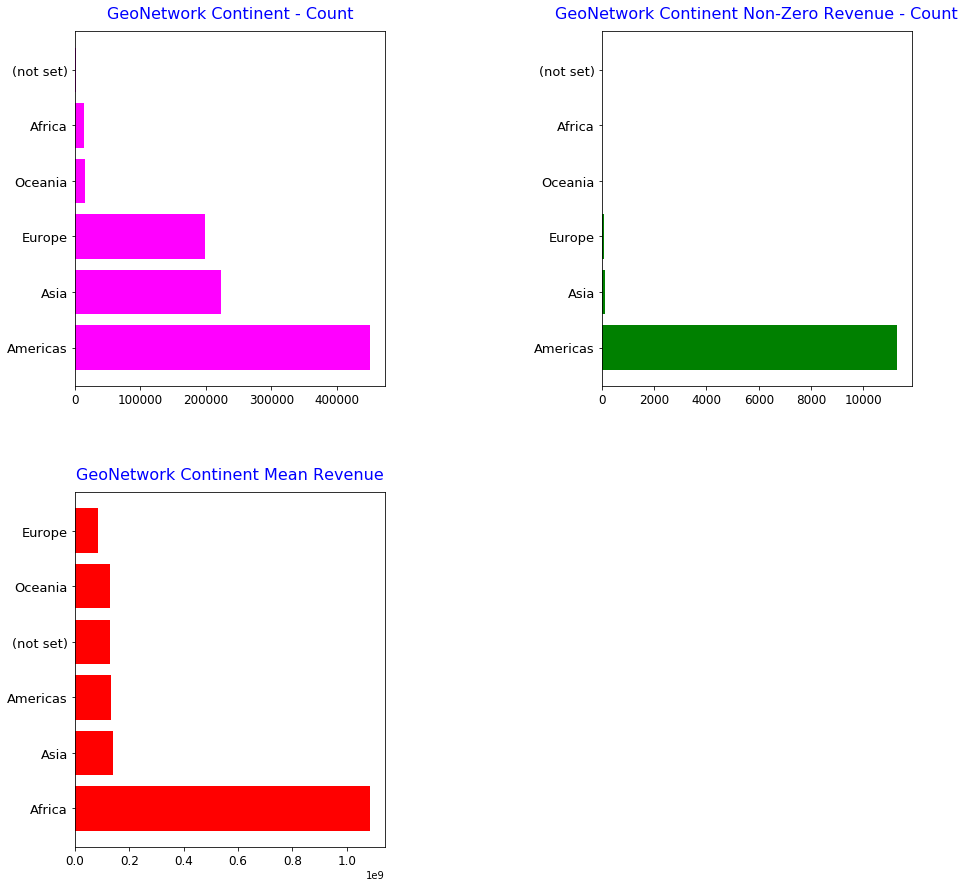

In [37]:
colors = ['magenta', 'green', 'red']
titles = ['GeoNetwork Continent - Count', 'GeoNetwork Continent Non-Zero Revenue - Count', 
          'GeoNetwork Continent Mean Revenue']

geoNetwork_continent_agg_df, cols_list = cal_agg_df('geoNetwork_continent')
plot_multiple_bars(cols_list, geoNetwork_continent_agg_df, titles, colors, ws = 0.7, hs = 0.3)

### GeoNetwork Country

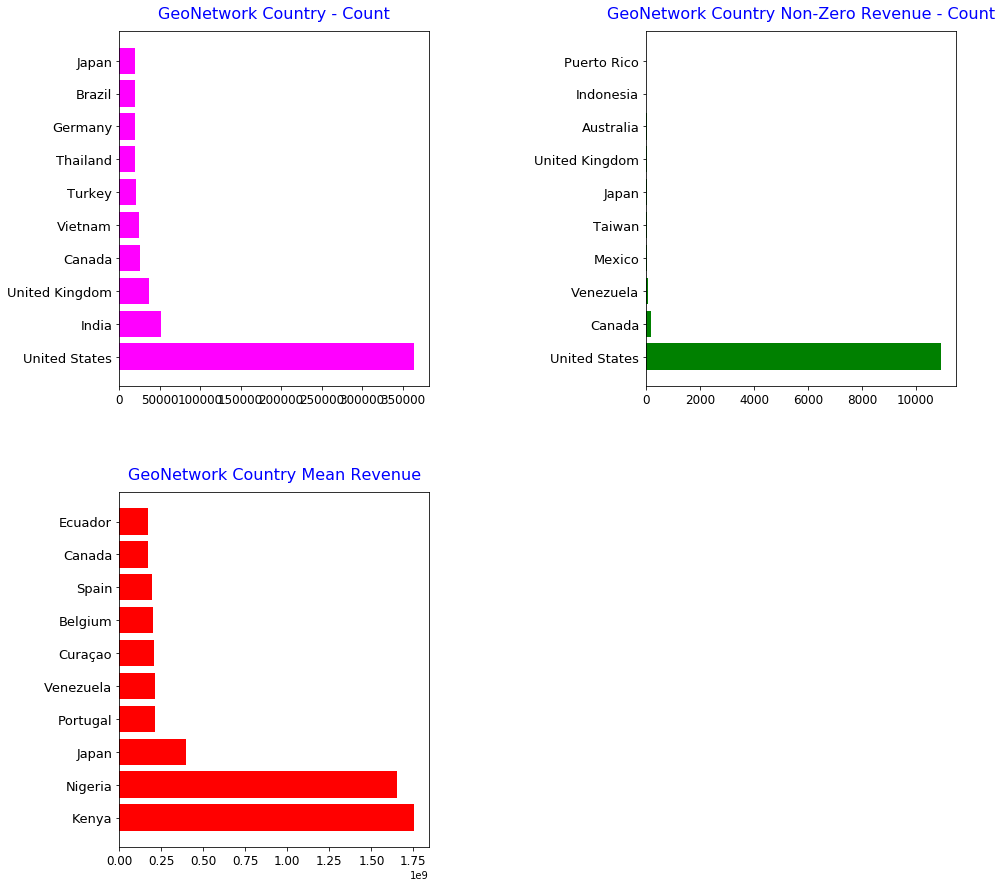

In [38]:
colors = ['magenta', 'green', 'red']
titles = ['GeoNetwork Country - Count', 'GeoNetwork Country Non-Zero Revenue - Count', 
          'GeoNetwork Country Mean Revenue']

geoNetwork_country_agg_df, cols_list = cal_agg_df('geoNetwork_country')
plot_multiple_bars(cols_list, geoNetwork_country_agg_df, titles, colors, ws = 0.7, hs = 0.3)

### GeoNetwork Metro

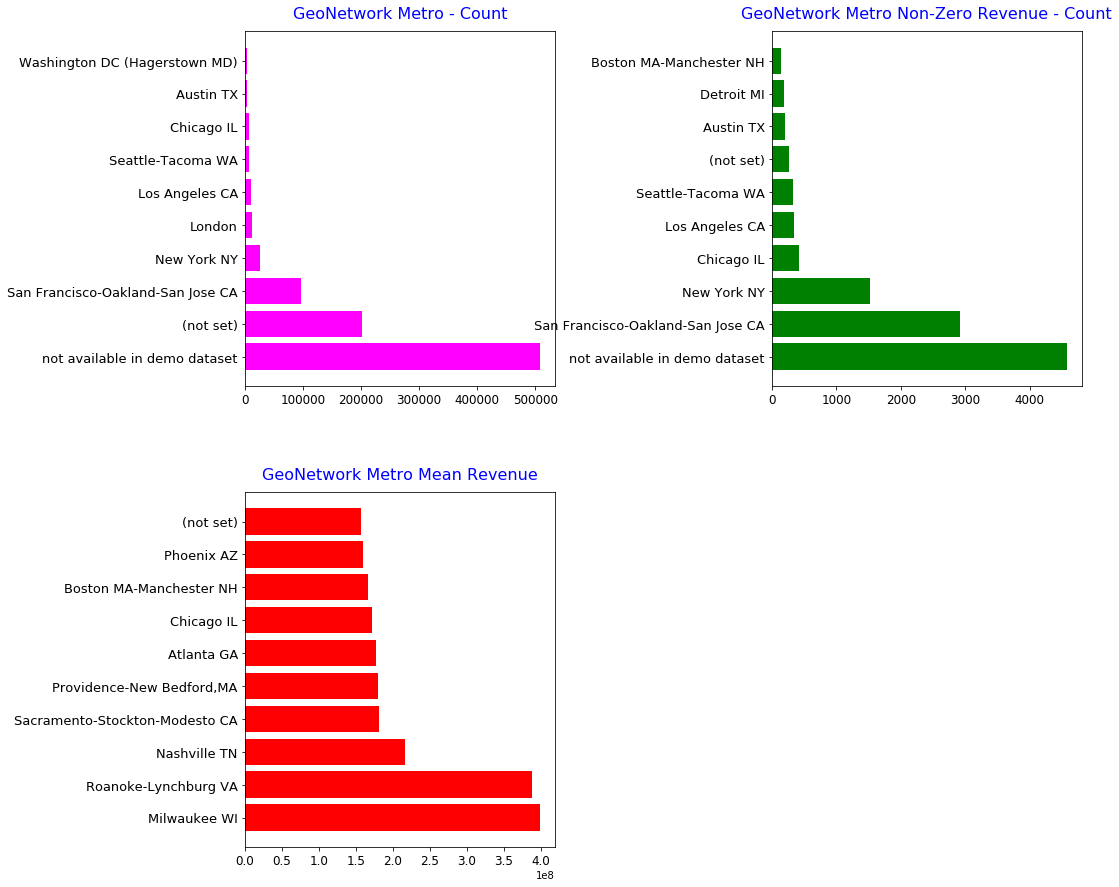

In [39]:
colors = ['magenta', 'green', 'red']
titles = ['GeoNetwork Metro - Count', 'GeoNetwork Metro Non-Zero Revenue - Count', 
          'GeoNetwork Metro Mean Revenue']

geoNetwork_metro_agg_df, cols_list = cal_agg_df('geoNetwork_metro')
plot_multiple_bars(cols_list, geoNetwork_metro_agg_df, titles, colors, ws = 0.7, hs = 0.3)

### GeoNetwork Domain

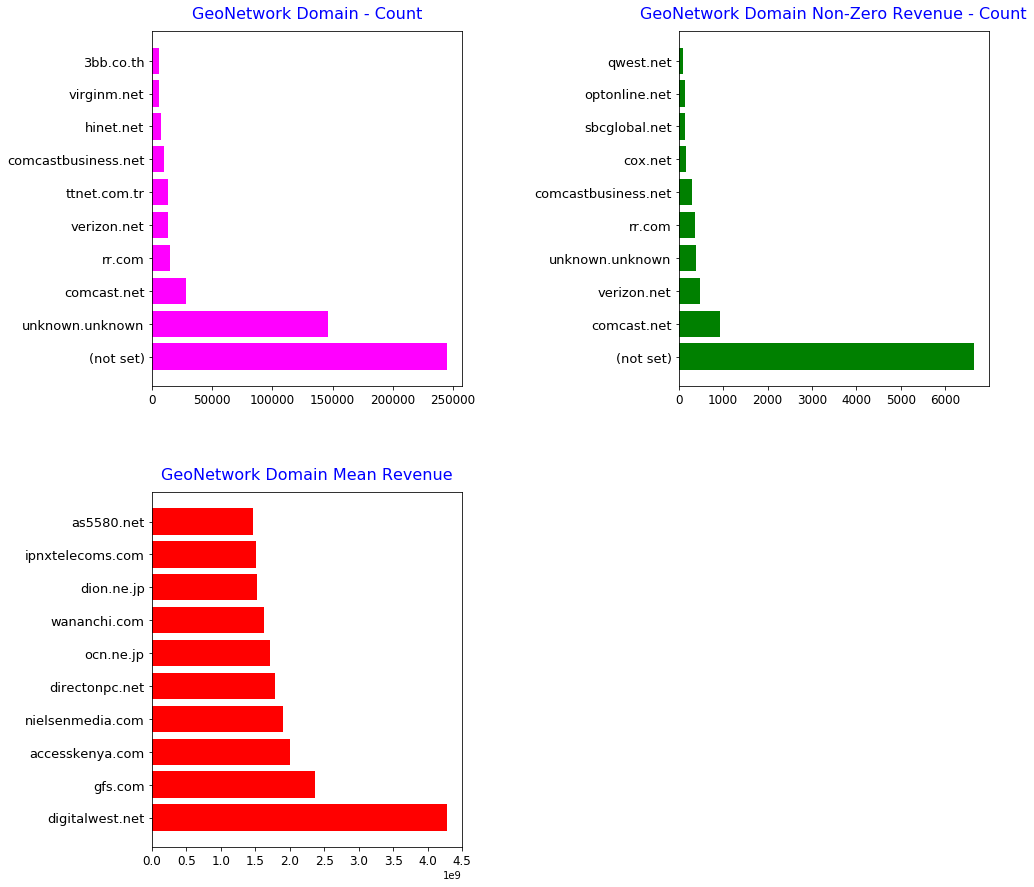

In [40]:
colors = ['magenta', 'green', 'red']
titles = ['GeoNetwork Domain - Count', 'GeoNetwork Domain Non-Zero Revenue - Count', 
          'GeoNetwork Domain Mean Revenue']

geoNetwork_networkDomain_agg_df, cols_list = cal_agg_df('geoNetwork_networkDomain')
plot_multiple_bars(cols_list, geoNetwork_networkDomain_agg_df, titles, colors, ws = 0.7, hs = 0.3)

### GeoNetwork Region

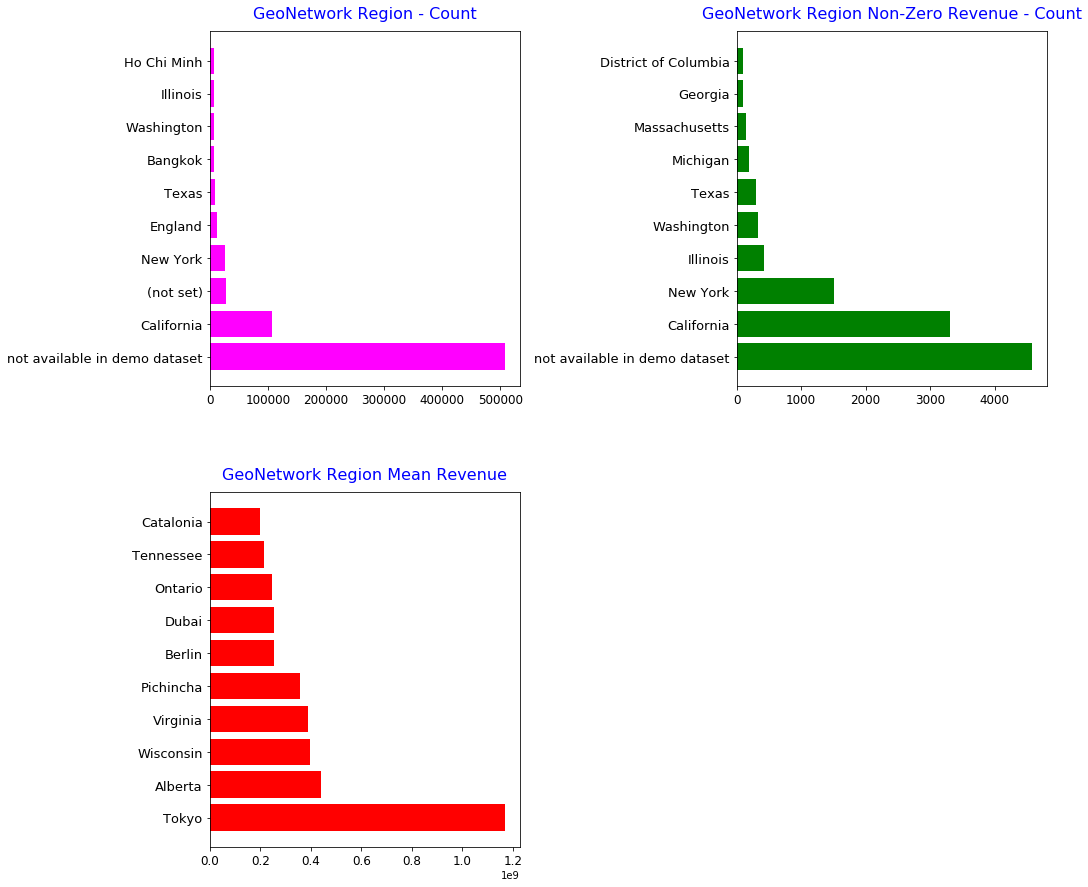

In [41]:
colors = ['magenta', 'green', 'red']
titles = ['GeoNetwork Region - Count', 'GeoNetwork Region Non-Zero Revenue - Count', 
          'GeoNetwork Region Mean Revenue']

geoNetwork_region_agg_df, cols_list = cal_agg_df('geoNetwork_region')
plot_multiple_bars(cols_list, geoNetwork_region_agg_df, titles, colors, ws = 0.7, hs = 0.3)

### GeoNetwork SubContinent

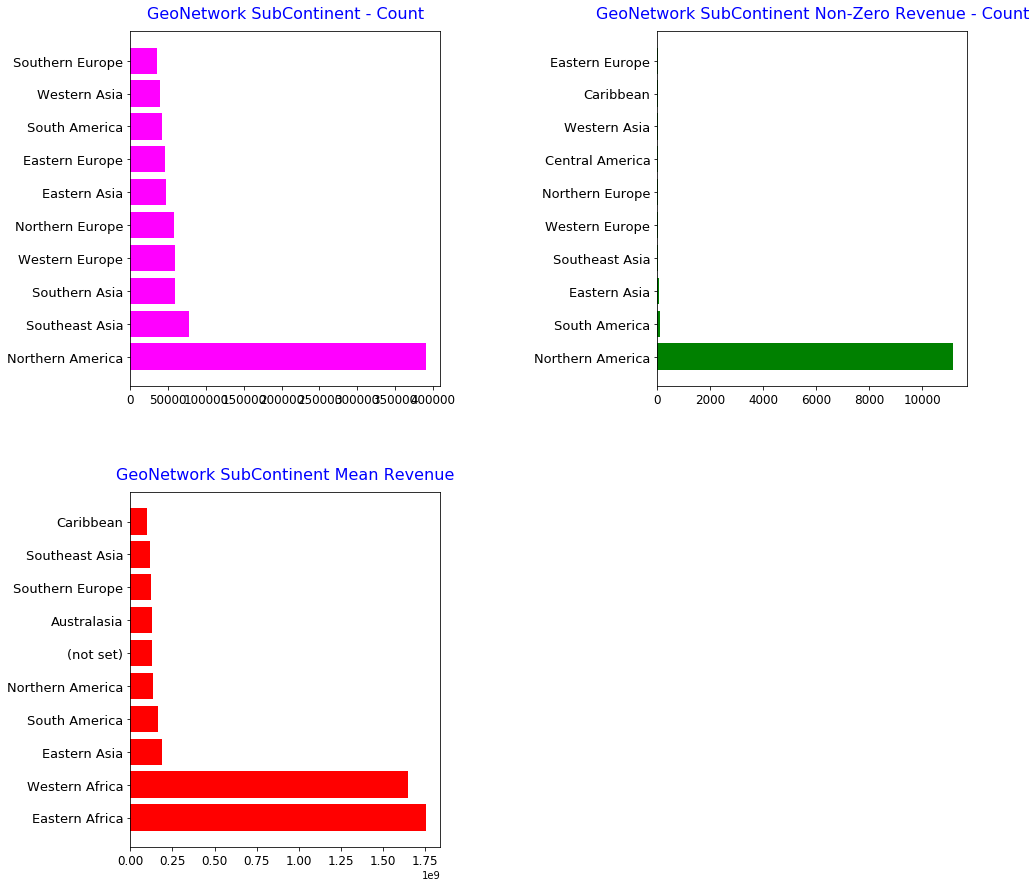

In [42]:
colors = ['magenta', 'green', 'red']
titles = ['GeoNetwork SubContinent - Count', 'GeoNetwork SubContinent Non-Zero Revenue - Count', 
          'GeoNetwork SubContinent Mean Revenue']

geoNetwork_subContinent_agg_df, cols_list = cal_agg_df('geoNetwork_subContinent')
plot_multiple_bars(cols_list, geoNetwork_subContinent_agg_df, titles, colors, ws = 0.7, hs = 0.3)

### Inferences

- We can see that America has both higher number of counts as well as highest number of counts where the revenue is non-zero
- Though Asia and Europe has high number of counts, the number of non-zero revenue counts from these continents are comparatively low.
- Africa has highest mean revenue as compare to Asia, America and Europe.
- By Region, Tokyo has highest mean revenue.
- If the network domain is "unknown.unknown" rather than "(not set)", then the number of counts with non-zero revenue tend to be lower.

- If the network metro is "not set" rather than "(not available in domo set)", then the number of counts with non-zero revenue tend to be lower.

In [43]:
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df.index[::-1],
        x=df.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [44]:
def multiple_horizontal_bar_chart(titles, fig_title, fn, features, head_val, colors, nrows=2, ncols=3, vs=0.08, hs=0.10, h=1200, w=1100):
    # Creating subplots
    fig = tools.make_subplots(rows=nrows, cols=ncols, vertical_spacing=vs, horizontal_spacing=hs, subplot_titles=titles)

    for feature in features:
        row_ind = features.index(feature)
        agg_df = train_df.groupby(feature)['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
        agg_df.columns = ["count", "count of non-zero revenue", "mean"]
        agg_df = agg_df.sort_values(by="count", ascending=False)
        
        for col in agg_df.columns:
            col_ind = list(agg_df.columns).index(col)
            trace = horizontal_bar_chart(agg_df[str(col)].head(head_val), colors[row_ind])
            fig.append_trace(trace, row_ind+1, col_ind+1)
            
    fig['layout'].update(height=h, width=w, paper_bgcolor='rgb(233,233,233)', title=fig_title)
    py.iplot(fig, filename=fn)

## Visitor Profile

- we will explore all features regarding visitor **totals_pageviews** and **totals_hits**.

In [45]:
titles = ["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count","Total Pageviews - Mean Revenue", 
          "Total Hits - Count", "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"]
fig_title = "Visitor Profile Plots"
fn = 'visitor-profile-plots'
features = ['totals_pageviews', 'totals_hits']
head_val = 60
colors = ['cyan', 'black']

multiple_horizontal_bar_chart(titles, fig_title, fn, features, head_val, colors, nrows=2, ncols=3, vs=0.08, hs=0.10, h=1800, w=1100)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



### Inferences

- Count plot shows decreasing nature i.e. we have a very high total count for less number of hits and page views per visitor transaction and the overall count decreases when the number of hits per visitor transaction increases.
- On the other hand, we can clearly see that when the number of hits / pageviews per visitor transaction increases, we see that there is a high number of non-zero revenue counts upto a limit (~18) and then start decreasing.

## Traffic Source

In [46]:
titles = ["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count",
          "Traffic Source Medium - Mean Revenue"]

fig_title = "Visitor Profile Plots"
fn = 'visitor-profile-plots'

features = ['trafficSource_source', 'trafficSource_medium']

head_val = 10
colors = ['green', 'purple']

multiple_horizontal_bar_chart(titles, fig_title, fn, features, head_val, colors, nrows=2, ncols=3, vs=0.15, hs=0.15, h=1000, w=1400)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



### Inferences

- In the traffic source plot, though Youtube has high number of counts in the dataset, the number of non-zero revenue counts are very less.
- Google plex has a high ratio of non-zero revenue count to total count in the traffic source plot.
- On the traffic source medium, "referral" has more number of non-zero revenue count compared to "organic" medium.
- df has very less overall count and count of non-zero revenue but has highest mean revenue.
- cpm has very less overall count and count of non-zero revenue but has highest mean revenue.

### Date Exploration

In [47]:
def scatter_plot(df, color):
    trace = go.Scatter(
        x = df.index,
        y = df.values,
        showlegend = True,
        marker = dict(
            color = color
        )
    )
    
    return trace

In [48]:
train_df['date'] = train_df['date'].apply(lambda x : datetime.date(int(str(x)[:4]),
                   int(str(x)[4:6]), int(str(x)[6:])))
agg_df = train_df.groupby('date')['totals_transactionRevenue'].agg(['size', 'count'])
agg_df.columns = ["count", "count of non-zero revenue"]
agg_df = agg_df.sort_index()

In [49]:
trace1 = scatter_plot(agg_df['count'], 'red')
trace2 = scatter_plot(agg_df['count of non-zero revenue'], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



### Inferences:

- We have data from 1 Aug, 2016 to 31 July, 2017 in our training dataset
- In Nov 2016, though there is an increase in the count of visitors, there is no increase in non-zero revenue counts during that time period (relative to the mean). However, there is an increase in non-zero revenue count in Dec 2016 even the overall count is reducing.

In [50]:
test_df['date'] = test_df['date'].apply(lambda x : datetime.date(int(str(x)[:4]),
                   int(str(x)[4:6]), int(str(x)[6:])))

agg_df = test_df.groupby('date')['fullVisitorId'].size()

In [51]:
trace = scatter_plot(agg_df, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In the test set, we have dates from 2 Aug, 2017 to 30 Apr, 2018. So there are no common dates between train and test set. So it might be a good idea to do time based validation for this dataset.

### Compare features in train and test set

- First we will see if there are any features in train set that are not in test set. If yes, we will remove those features.

In [52]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'totals_transactionRevenue', 'trafficSource_campaignCode'}


- So apart from target variable, there is one more variable **"trafficSource.campaignCode"** not present in test dataset. So we need to remove this variable while building models. Also we can drop the **constant variables** which we have seen earlier.

- Also we can remove the "sessionId" as it is a unique identifier of the visit.

In [53]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ['trafficSource_campaignCode'], axis = 1)
test_df = test_df.drop(cols_to_drop, axis = 1)

In [54]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source'],
      dtype='object')

### Handlie Missing Values

- Impute 0 for missing target values
- label encode the categorical variables and convert the numerical variables to float
- Label Encoding is useful for decision trees Algorithms like Random Forest etc. Label econding can be used here because total transactionRevenue for one category of a features is higher as compare to other or vice versa.

In [55]:
train_df['totals_transactionRevenue'].fillna(0, inplace = True)
train_y = train_df['totals_transactionRevenue'].values
train_id = train_df['fullVisitorId'].values
test_id = test_df['fullVisitorId'].values

In [56]:
catg_cols = ["channelGrouping", "device_browser", 
            "device_deviceCategory", "device_operatingSystem", 
            "geoNetwork_city", "geoNetwork_continent", 
            "geoNetwork_country", "geoNetwork_metro",
            "geoNetwork_networkDomain", "geoNetwork_region", 
            "geoNetwork_subContinent", "trafficSource_adContent", 
            "trafficSource_adwordsClickInfo.adNetworkType", 
            "trafficSource_adwordsClickInfo.gclId", 
            "trafficSource_adwordsClickInfo.page", 
            "trafficSource_adwordsClickInfo.slot", "trafficSource_campaign",
            "trafficSource_keyword", "trafficSource_medium", 
            "trafficSource_referralPath", "trafficSource_source",
            'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_isTrueDirect']

for col in catg_cols:
    label = preprocessing.LabelEncoder()
    label.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = label.transform(list(train_df[col].values.astype('str')))
    test_df[col] = label.transform(list(test_df[col].values.astype('str')))

In [57]:
num_cols = ["totals_hits", "totals_pageviews", "visitNumber", "visitStartTime", 'totals_bounces',  'totals_newVisits']

for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

In [58]:
# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date'] <= datetime.date(2017,5,31)]
val_df = train_df[train_df['date'] > datetime.date(2017,5,31)]

dev_y = np.log1p(dev_df["totals_transactionRevenue"].values)
val_y = np.log1p(val_df["totals_transactionRevenue"].values)

In [59]:
dev_X = dev_df[catg_cols + num_cols] 
val_X = val_df[catg_cols + num_cols]

test_X = test_df[catg_cols + num_cols]

### Make Model

In [60]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label = train_y)
    lgval = lgb.Dataset(val_X, label = val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets = [lgval], early_stopping_rounds = 100, verbose_eval = 100)
    
    pred_test_y = model.predict(test_X, num_iteration = model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration = model.best_iteration)
    
    return pred_test_y, model, pred_val_y

### Train Model

In [61]:
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69586
[200]	valid_0's rmse: 1.69126
[300]	valid_0's rmse: 1.69175
Early stopping, best iteration is:
[254]	valid_0's rmse: 1.69087


we need to do a sum for all the transactions of the user and then do a log transformation on top. Let us also make the values less than 0 to 0 as transaction revenue can only be 0 or more.

In [62]:
from sklearn import metrics

pred_val[pred_val < 0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId" : val_df['fullVisitorId'].values})
val_pred_df["transactionRevenue"] = val_df["totals_transactionRevenue"].values

# to remove the effect of log which we did before model training -> exp(x) - 1
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)

val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

### RMSE on Validation Set

In [64]:
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df['transactionRevenue']), 
                                         np.log1p(val_pred_df['PredictedRevenue']))))

1.7430425960055989


### Submission on Kaggle

In [79]:
sub_df = pd.DataFrame({"fullVisitorId" : test_id})
pred_test[pred_test < 0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("E:/Data Science/Machine Learning/Google Analytics Customer Revenue Prediction/lgb_prediction.csv", index = False)

In [80]:
# non_const_cols